In [36]:
import pandas as pd
import seaborn as sn

import base_functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Desafio

Dentre os desafios propostos, o escolhido foi:

- *"Como predizer o desempenho dos estudantes nas avaliações finais"*.

Cada estudante em cada módulo faz em média quatro provas, e a nota final consiste de uma média ponderada dessas notas, que define a aprovação ou não do estudante. Destarte, pode-se pensar em "avaliações finais" em dois níveis de agregação distintos:
- primeiro é o de tentar prever o desempenho em cada prova, uma vez que não há uma avaliação final *per se*, e sim um conjunto de avaliações para cada módulo;
- a outra interpretação possível é entender a avaliação final como a média das avaliações que é também o resultado final de desempenho.

Aqui utilizamos a segunda interpretação, por motivo de simplicidade e performance preditiva, uma vez que ambas foram testadas. Os testes e análises não foram exaustivamente incluídos nesse texto visando manter uma linha condutória com leitura mais fluída.

Pontuo também que o texto no formato markdown será feito em português, e os comentários relacionados as operações computacionais e feitos na forma de comentários no código serão feitos em inglês por convenção.


# Entendimento dos dados

Essa seção consiste de três etapas: <br>
1. Apresentação da descrição dos dados presente no link https://analyse.kmi.open.ac.uk/open_dataset.

2. Exposição dos dados e de algumas propriedades *e.g* cardinalidade.

3. Agregação dos diferentes datasets visando criar um dataset analítico inicial.

<img src="model.png">

O banco de dados é organizado em sete diferentes tabelas, descritas na imagem acima. Descrevendo de forma simples, as tabelas são divididas nas que descrevem:
- O estudante
- Os módulos
- As atividades no VLE (virtual learning environment).

O objetivo de agregação é criar uma tabela única que tenha como chave composta a triade **[Estudante | Curso | Semestre]**. Dessa forma, assume-se que o mesmo estudante, cursando cursos diferentes, ou o mesmo curso em outro momento do tempo será tratado de forma independente. 

# Descrição do problema, variáveis, e visualização dos dados de cada tabela

As descrições foram tiradas integralmente da página de referência.

**Description** <br>
"This page introduces the anonymised Open University Learning Analytics Dataset (OULAD). **It contains data about courses, students and their interactions with Virtual Learning Environment (VLE) for seven selected courses (called modules)**. Presentations of courses start in February and October - they are marked by “B” and “J” respectively. The dataset consists of tables connected using unique identifiers. All tables are stored in the csv format."

In [21]:
df_0 = pd.read_csv("../data/assessments.csv")

**This file contains information about assessments in module-presentations. Usually, every presentation has a number of assessments followed by the final exam.** <br> 

**code_module** – identification code of the module, to which the assessment belongs. <br>
**code_presentation** - identification code of the presentation, to which the assessment belongs. <br>
**id_assessment** – identification number of the assessment. <br>
**assessment_type** – type of assessment. Three types of assessments exist: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam). <br>
**date** – information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero). <br>
**weight** - weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.

In [22]:
df_0.head(3)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0


In [8]:
base_functions.describe_(df_0)

shape (206, 6)
#############
Contagem de categorias: code_module
FFF    52
BBB    42
DDD    35
GGG    30
CCC    20
EEE    15
AAA    12
Name: code_module, dtype: int64
#############
Contagem de categorias: code_presentation
2014J    57
2014B    57
2013J    53
2013B    39
Name: code_presentation, dtype: int64
#############
Contagem de categorias: assessment_type
TMA     106
CMA      76
Exam     24
Name: assessment_type, dtype: int64


In [10]:
df_1 = pd.read_csv("../data/courses.csv")

**File contains the list of all available modules and their presentations.** <br><br>
**code_module** – code name of the module, which serves as the identifier. <br>
**code_presentation** – code name of the presentation. It consists of the year and “B” for the presentation starting in February and “J” for the presentation starting in October. <br>
**length** - length of the module-presentation in days. <br><br>
The structure of <span style="color:red">B and J presentations may differ and therefore it is good practice to analyse the B and J presentations separately</span>.
Nevertheless, for some presentations the corresponding previous B/J presentation do not exist and therefore the J presentation must be used to inform the B presentation or vice versa. In the dataset this is the case of CCC, EEE and GGG modules. <br>

In [7]:
df_1.head(3)

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268


In [11]:
base_functions.describe_(df_1)

shape (22, 3)
#############
Contagem de categorias: code_module
BBB    4
FFF    4
DDD    4
EEE    3
GGG    3
AAA    2
CCC    2
Name: code_module, dtype: int64
#############
Contagem de categorias: code_presentation
2014J    7
2014B    6
2013J    6
2013B    3
Name: code_presentation, dtype: int64


In [14]:
# join df_0 and df_1
df_0_1 = df_0.merge(df_1, on=['code_module', 'code_presentation'])

In [12]:
df_2 = pd.read_csv("../data/studentAssessment.csv")

**This file contains the results of students’ assessments.** <br><br>

If the student does not submit the assessment, no result is recorded. The final exam submissions is missing, if the result of the assessments is not stored in the system. This file contains the following columns: <br> <br>
**id_assessment** – the identification number of the assessment. <br>
**id_student** – a unique identification number for the student. <br>
**date_submitted** – the date of student submission, measured as the number of days since the start of the module presentation. <br>
**is_banked** – a status flag indicating that the assessment result has been transferred from a previous presentation. <br>
**score** – the student’s score in this assessment. The range is from 0 to 100. The score lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100.

In [11]:
df_2.head(3)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0


In [13]:
df_2.shape

(173912, 5)

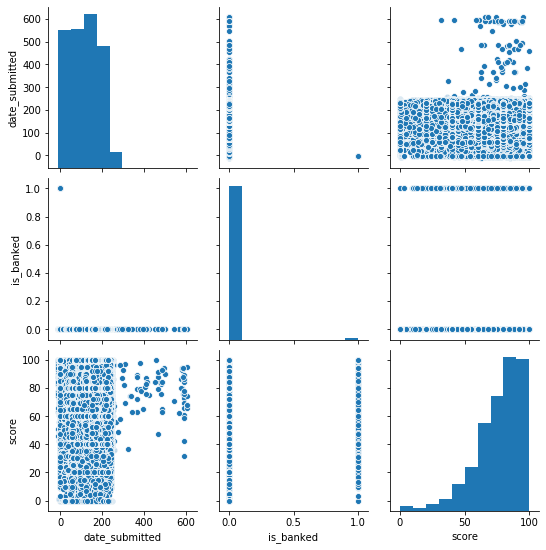

In [26]:
sn.pairplot(df_2.drop(columns=['id_assessment', 'id_student']))

In [49]:
# join df_2 with the previous two.
df_0_1_2 = df_2.merge(df_0_1, on = ['id_assessment'])

In [48]:
df_3 = pd.read_csv("../data/studentInfo.csv")

**This file contains demographic information about the students together with their results.** <br> <br>
**code_module** – an identification code for a module on which the student is registered. <br>
**code_presentation** - the identification code of the presentation during which the student is registered on the module. <br>
**id_student** – a unique identification number for the student. <br>
**gender** – the student’s gender. <br>
**region** – identifies the geographic region, where the student lived while taking the module-presentation. <br>
**highest_education** – highest student education level on entry to the module presentation. <br> 
**imd_band** – specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation. <br>
**age_band** – band of the student’s age. <br>
**num_of_prev_attempts** – the number times the student has attempted this module. <br>
**studied_credits** – the total number of credits for the modules the student is currently studying. <br>
**disability** – indicates whether the student has declared a disability. <br>
**final_result** – student’s final result in the module-presentation. <br>

In [13]:
df_3.head(3)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn


In [37]:
desc(df_3)

shape (32593, 12)
code_module
BBB    7909
FFF    7762
DDD    6272
CCC    4434
EEE    2934
GGG    2534
AAA     748
Name: code_module, dtype: int64
code_presentation
2014J    11260
2013J     8845
2014B     7804
2013B     4684
Name: code_presentation, dtype: int64
gender
M    17875
F    14718
Name: gender, dtype: int64
region
Scotland                3446
East Anglian Region     3340
London Region           3216
South Region            3092
North Western Region    2906
West Midlands Region    2582
South West Region       2436
East Midlands Region    2365
South East Region       2111
Wales                   2086
Yorkshire Region        2006
North Region            1823
Ireland                 1184
Name: region, dtype: int64
highest_education
A Level or Equivalent          14045
Lower Than A Level             13158
HE Qualification                4730
No Formal quals                  347
Post Graduate Qualification      313
Name: highest_education, dtype: int64
imd_band
20-30%     3654
30-40

In [50]:
# join df_3 with the previous three.
df_0_1_2_3 = df_0_1_2.merge(df_3, on=['code_module', 'code_presentation', 'id_student'])

In [51]:
df_4 = pd.read_csv("../data/studentRegistration.csv")

**This file contains information about the time when the student registered for the module presentation. For students who unregistered the date of unregistration is also recorded.** <br> <br>
**code_module** – an identification code for a module.  <br>
**code_presentation** - the identification code of the presentation.  <br>
**id_student** – a unique identification number for the student.  <br>
**date_registration** – the date of student’s registration on the module presentation, this is the number of days measured relative to the start of the module-presentation (e.g. the negative value -30 means that the student registered to module presentation 30 days before it started).  <br>
**date_unregistration** – date of student unregistration from the module presentation, this is the number of days measured relative to the start of the module-presentation. Students, who completed the course have this field empty. Students who unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file.

In [15]:
df_4.head(3)

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0


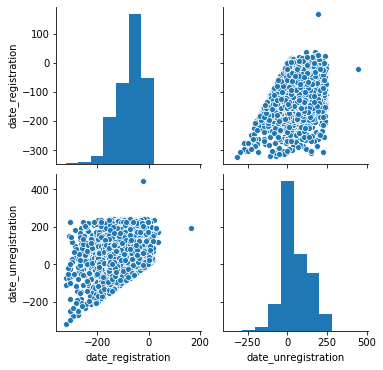

In [29]:
sn.pairplot(df_4.drop(columns=['id_student']))

In [52]:
# join df_4 with the previous four.
df_0_1_2_3_4 = df_0_1_2_3.merge(df_4, on=['code_module', 'code_presentation', 'id_student'])

In [53]:
df_5 = pd.read_csv("../data/studentVle.csv")

**The studentVle.csv file contains information about each student’s interactions with the materials in the VLE. (virtual learning environment)** <br> <br>
**code_module** – an identification code for a module. <br>
**code_presentation** - the identification code of the module presentation. <br>
**id_student** – a unique identification number for the student. <br>
**id_site** - an identification number for the VLE material. <br>
**date** – the date of student’s interaction with the material measured as the number of days since the start of the module-presentation. <br>
**sum_click** – the number of times a student interacts with the material in that day.

In [17]:
df_5.head(3)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1


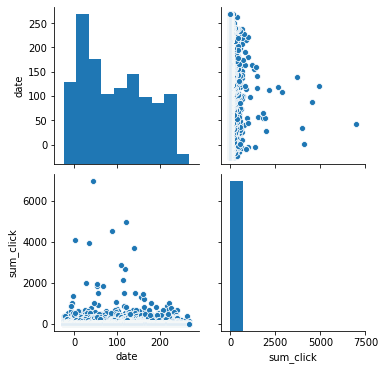

In [32]:
sn.pairplot(df_5.drop(columns=['id_site', 'id_student']))

In [37]:
df_5['sum_click'].describe()

count   10655280.000
mean           3.717
std            8.849
min            1.000
25%            1.000
50%            2.000
75%            3.000
max         6977.000
Name: sum_click, dtype: float64

In [54]:
# Here we separete just the sum_click variable, which is the one that keeps a
#  meaningful interpretation after agreggation. We could easily perform this agreggation on the 
#   next step of the analysis instead of now.
grouped_df_5 = df_5.drop(columns=[
    'id_site', 'date']).groupby(
     by=['code_module', 'code_presentation', 'id_student']
     ).sum().reset_index()

# Here we agregate the df_5 with all the previous. 
df_0_1_2_3_4_5 = df_0_1_2_3_4.merge(
    grouped_df_5, on=['code_module', 'code_presentation', 'id_student'])

In [18]:
df_6 = pd.read_csv("../data/vle.csv")

**The csv file contains information about the available materials in the VLE. Typically these are html pages, pdf files, etc. Students have access to these materials online and their interactions with the materials are recorded.** <br> <br>
**id_site** – an identification number of the material. <br>
**code_module** – an identification code for module. <br>
**code_presentation** - the identification code of presentation. <br>
**activity_type** – the role associated with the module material. <br>
**week_from** – the week from which the material is planned to be used. <br>
**week_to** – week until which the material is planned to be used. <br>

In [19]:
df_6.head(3)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN


In [76]:
df_6.shape

(6364, 6)

In [15]:
# I chose to not include the df_6 in the analytical df, since I understand that the activity 
#  type var couldn't be grouped by student, and the week_from and week_to have no simple 
#   interpretation once we group the data for each student.

### Exportação do primeiro dataset analítico.

In [98]:
df_0_1_2_3_4_5.to_csv('base_data.csv', index=False)